In [3]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
import warnings
warnings.filterwarnings("ignore")

In [9]:
n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

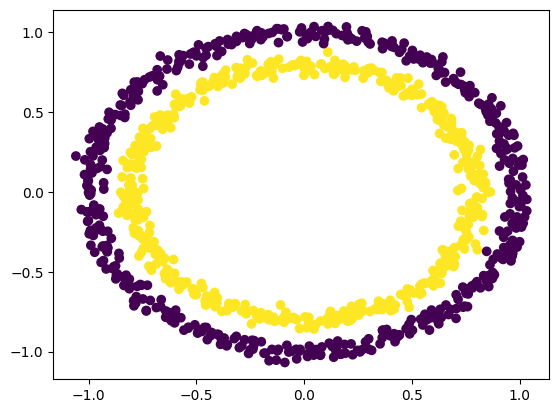

In [5]:
plt.scatter(x=X[:, 0], y=X[: , 1], c=y)

In [6]:
X.shape, y.shape # this is not torch tensors

((1000, 2), (1000,))

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
# construct our model with non-linearity
from torch import nn
class ClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model = ClassificationModel().to(device)

In [14]:
model.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.4814,  0.5793],
                      [-0.5039,  0.6963],
                      [ 0.4074, -0.0396],
                      [ 0.6720, -0.0671],
                      [-0.4068,  0.5461],
                      [-0.0529,  0.7050],
                      [ 0.0350,  0.3976],
                      [ 0.0148, -0.6416],
                      [ 0.3594,  0.5532],
                      [-0.6098, -0.6083]], device='cuda:0')),
             ('layer_1.bias',
              tensor([ 0.2770,  0.1929, -0.1391, -0.2468, -0.4924, -0.5777, -0.1474,  0.2503,
                      -0.5125, -0.1965], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 8.1384e-02, -3.2785e-02,  3.0473e-01,  1.9594e-02, -1.0514e-01,
                        2.1800e-01, -2.4422e-01, -2.2194e-01, -1.6285e-02,  9.8482e-02],
                      [-1.4744e-01,  3.7175e-02, -1.3683e-01, -3.1153e-01, -1.1637e-01,
                        4.4709e-02, -2.8308e-01

In [24]:
# setup the loss and optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [16]:
# training model with non-linearity

In [17]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [26]:
epoch_counts = []
loss_values = []
test_loss_values = []
epochs = 1000

In [20]:
# calculate the accuracy - out of 100 examples what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [27]:
for epoch in range(epochs):
    # setup the training mode
    model.train()
    # forward propagate
    y_logits = model(X_train).squeeze()
    # convert logits to labels
    y_pred = torch.round(torch.sigmoid(y_logits))
    # calculate the loss 
    loss = loss_fn(y_logits, y_train)
    # calculate the accuracy
    acc = accuracy_fn(y_true=y_train, y_pred = y_pred)
    # prepare the backpropagation
    optimizer.zero_grad()
    # back propagate
    loss.backward()
    # gradient descent
    optimizer.step()
    # clear the enviroment for testing 
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc =  accuracy_fn(y_true=y_test, y_pred=test_pred)
    epoch_counts.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    if epoch % 10 == 0:
        print(f"Epoch{epoch} Loss {loss:.5f} Test loss{test_loss:.5f} Test accuracy: {test_acc:.2f}")

Epoch0 Loss 0.68669 Test loss0.68768 Test accuracy: 67.50
Epoch10 Loss 0.68665 Test loss0.68765 Test accuracy: 68.00
Epoch20 Loss 0.68662 Test loss0.68762 Test accuracy: 68.00
Epoch30 Loss 0.68658 Test loss0.68759 Test accuracy: 68.00
Epoch40 Loss 0.68654 Test loss0.68756 Test accuracy: 69.00
Epoch50 Loss 0.68650 Test loss0.68753 Test accuracy: 69.00
Epoch60 Loss 0.68646 Test loss0.68750 Test accuracy: 69.50
Epoch70 Loss 0.68642 Test loss0.68747 Test accuracy: 70.00
Epoch80 Loss 0.68639 Test loss0.68744 Test accuracy: 70.50
Epoch90 Loss 0.68635 Test loss0.68741 Test accuracy: 70.50
Epoch100 Loss 0.68631 Test loss0.68738 Test accuracy: 70.50
Epoch110 Loss 0.68627 Test loss0.68735 Test accuracy: 70.50
Epoch120 Loss 0.68623 Test loss0.68732 Test accuracy: 70.50
Epoch130 Loss 0.68619 Test loss0.68728 Test accuracy: 70.50
Epoch140 Loss 0.68615 Test loss0.68725 Test accuracy: 70.00
Epoch150 Loss 0.68611 Test loss0.68722 Test accuracy: 70.00
Epoch160 Loss 0.68607 Test loss0.68719 Test accurac

In [28]:
model.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model(X_test))).squeeze()

In [29]:
y_preds

tensor([1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.,
        1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0.,
        1., 1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
        1., 0.], device='cuda:0')

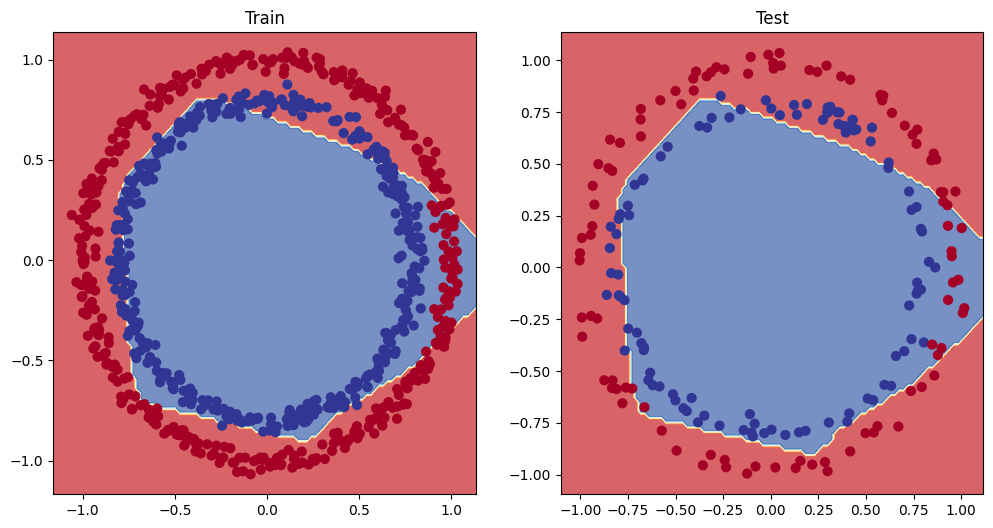

In [31]:
# print the decision boundary
from helper_functions import plot_predictions, plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2 ,1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1,2 ,2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)


**More improvements**
  
* Add more layers
* add more units in layers
* Fit for longer
* Change the activation functino
* change the learning rate
* Change the loss function